# Formula One Project: Final Report

DUE: December 10th, 2024 (Tue)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

In [1]:
# Importing Libraries
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import random
import logging
import warnings
import os

import fastf1
import fastf1.plotting
from fastf1.ergast.structure import FastestLap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Problem Statement
We are analyzing Formula One driver performance to understand and predict race outcomes based on various conditions. Specifically, we aim to:
1. Predict lap times based on weather and track conditions
2. Understand how different variables affect driver performance
3. Create models that can forecast race performance

This is primarily a regression problem, as we're predicting continuous values (lap times) based on multiple features.

In [2]:
# Set up FastF1 plotting and caching
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)
logging.disable(logging.INFO)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'Saudi Arabian Grand Prix', 'Dutch Grand Prix', 'Italian Grand Prix', 'Austrian Grand Prix', 'Hungarian Grand Prix', 'British Grand Prix', 'Belgian Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'São Paulo Grand Prix']

## Why these events, sessions, and years?

These events were chosen because they are all currently scheduled for the 2024 season, as well as having occurred in previous years. 

Each event has a specific set of conditions that may affect driver performance, for example:
- Bahrain: Hot and humid, with high track temperatures
- British: Cool and changeable, with frequent rain
- Belgian: Overcast and cool, with frequent weather changes
- United States: Very hot, with high track temperatures
- Mexico City: Cool and changeable, with frequent rain

As for years, we chose 2021 to 2024 because they are the most recent years for which data is available. In 2021, the regulations changed to allow for more overtaking, so the lap times became incomparable to that of previous years.

We chose to only use the 'Race' session because it is the most representative of a race condition, as opposed to qualifying, which can be very sporadic.

In [5]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    
if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)


core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'
core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
events      WARNING 	Correcting user input 'Sao Paulo Grand Prix' to 'São Paulo Grand Prix'
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
events      WARNING 	Correcting user input 'Sao

## Data Description
Our data comes from the FastF1 API, which provides detailed Formula One racing data. Each observation represents a single lap during a race or qualifying session, including:

Key Variables:
- **Time**: Timestamp of the lap
- **Driver**: Driver identifier
- **LapTime**: Time taken to complete the lap
- **Weather Conditions**:
  - TrackTemp: Track temperature in Celsius
  - AirTemp: Air temperature in Celsius
  - Humidity: Percentage
  - Rainfall: Boolean indicating presence of rain
- **Performance Metrics**:
  - Sector times (1,2,3)
  - Speed measurements at various points
  - Compound: Tire compound used
  - TyreLife: Age of tires in laps

Each lap is represented as a fixed-length vector containing these attributes, making it suitable for machine learning algorithms.

In [7]:
# Display a sample of the raw data
lap_data_combined.head()

,Time,Year,Event,Session,Driver,Team,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,FreshTyre,SpeedI1,SpeedI2,SpeedFL,SpeedST,LapTime_seconds
1,2021-01-01 00:41:37.134,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,2.0,0 days 00:02:22.263000,0 days 00:00:45.220000,0 days 00:01:00.086000,0 days 00:00:36.957000,MEDIUM,5.0,False,120.0,134.0,182.0,236.0,142.263
4,2021-01-01 00:48:28.044,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,5.0,0 days 00:02:11.534000,0 days 00:01:05.748000,0 days 00:00:41.956000,0 days 00:00:23.830000,HARD,1.0,True,231.0,251.0,275.0,213.0,131.534
5,2021-01-01 00:50:04.721,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,6.0,0 days 00:01:36.677000,0 days 00:00:30.990000,0 days 00:00:41.802000,0 days 00:00:23.885000,HARD,2.0,True,233.0,254.0,275.0,280.0,96.677
6,2021-01-01 00:51:41.675,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,7.0,0 days 00:01:36.954000,0 days 00:00:31.176000,0 days 00:00:41.678000,0 days 00:00:24.100000,HARD,3.0,True,232.0,252.0,274.0,282.0,96.954
8,2021-01-01 00:54:56.129,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,9.0,0 days 00:01:37.030000,0 days 00:00:31.256000,0 days 00:00:41.911000,0 days 00:00:23.863000,HARD,5.0,True,234.0,248.0,276.0,286.0,97.030


## Data Preprocessing Steps
1. Time Conversion:
   - Converting lap times from timedelta to seconds
   - Standardizing timestamps for weather correlation

2. Missing Value Handling:
   - Removing incomplete laps
   - Handling missing weather data

3. Feature Engineering:
   - Creating derived features from raw data
   - Normalizing numerical values

In [8]:
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

In [9]:
# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

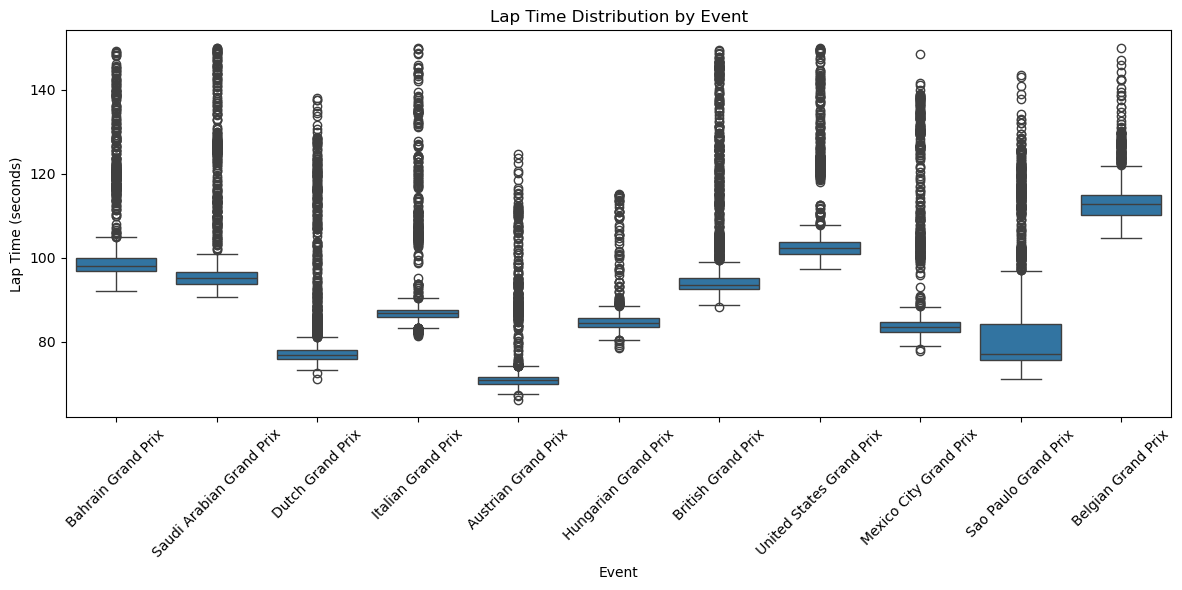

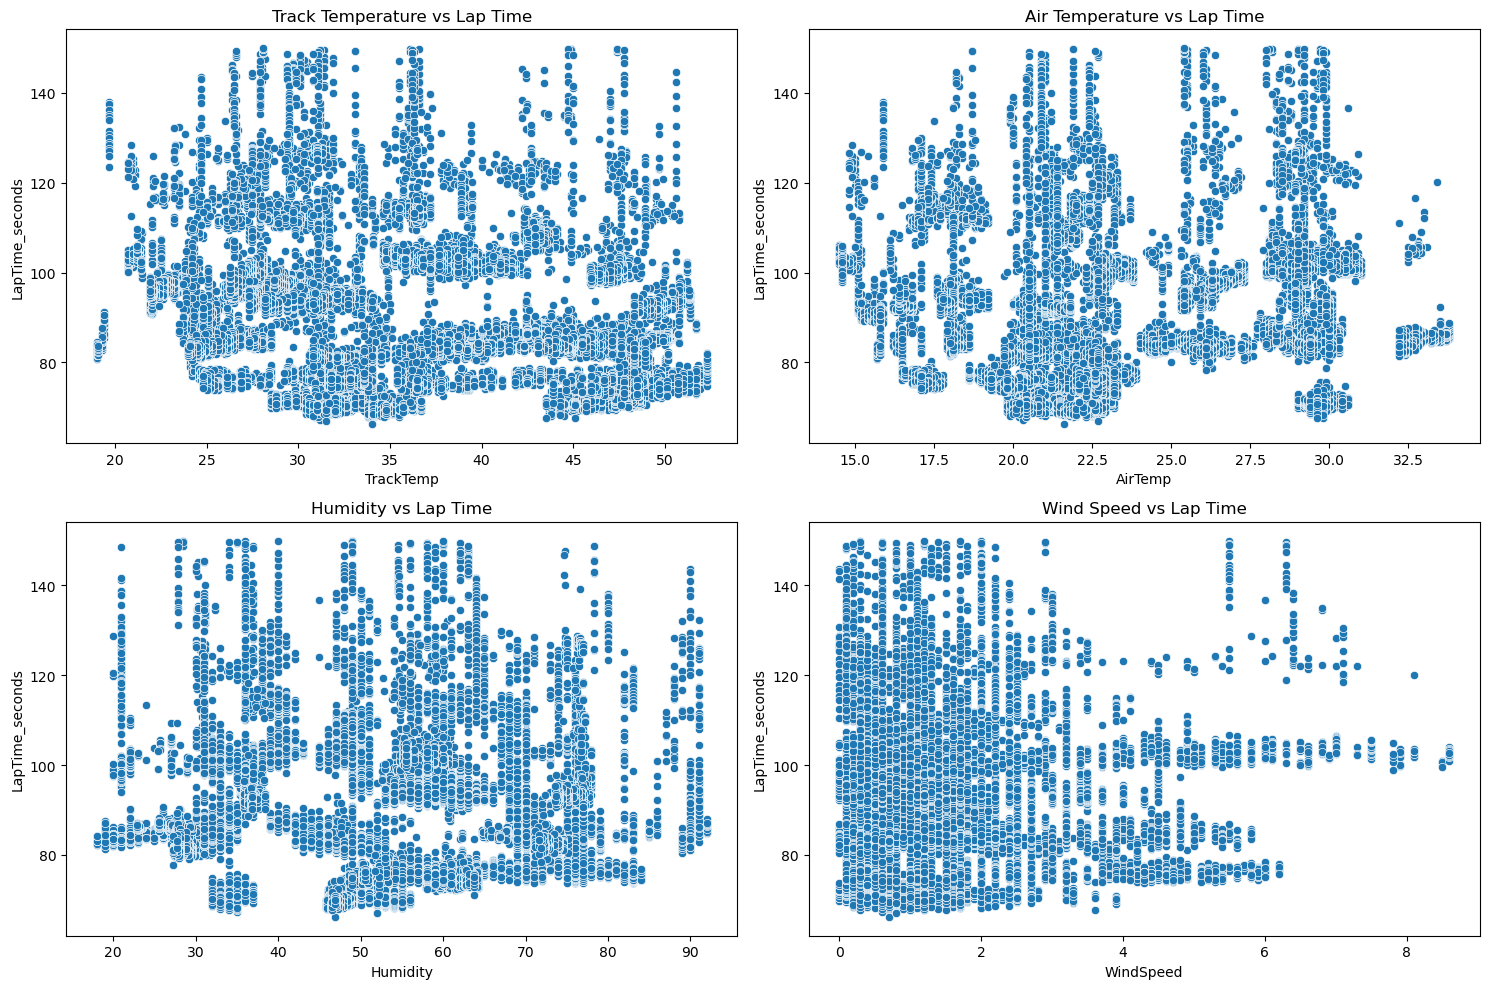

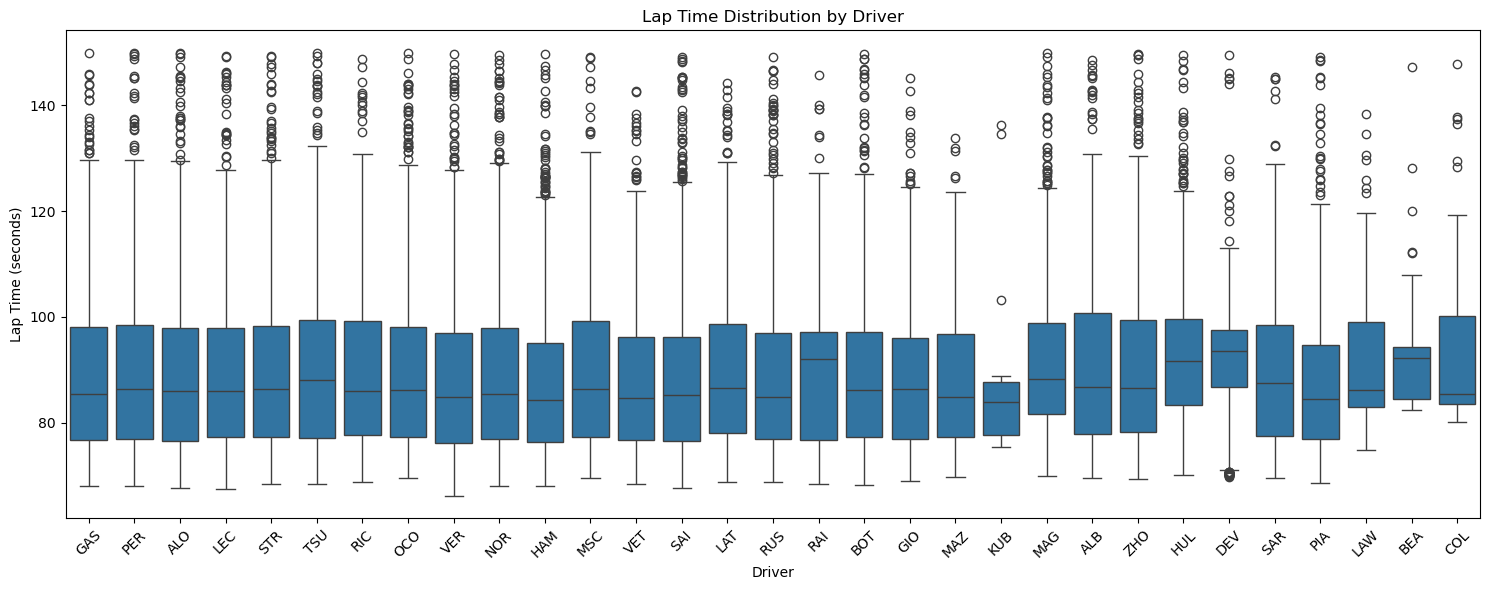

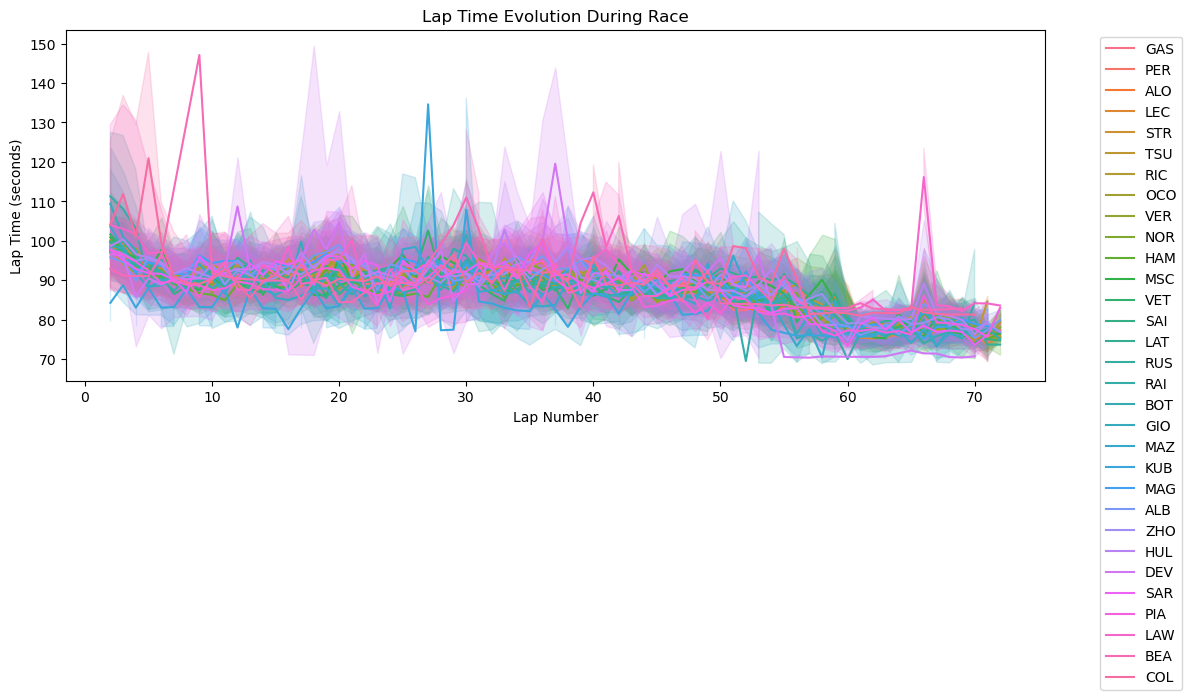

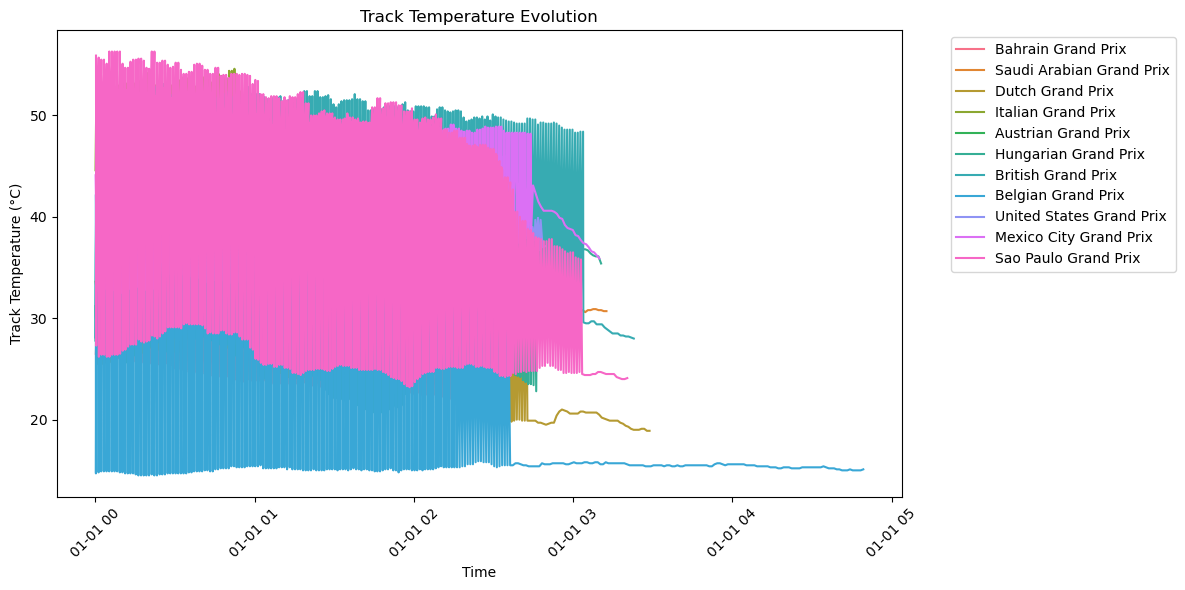

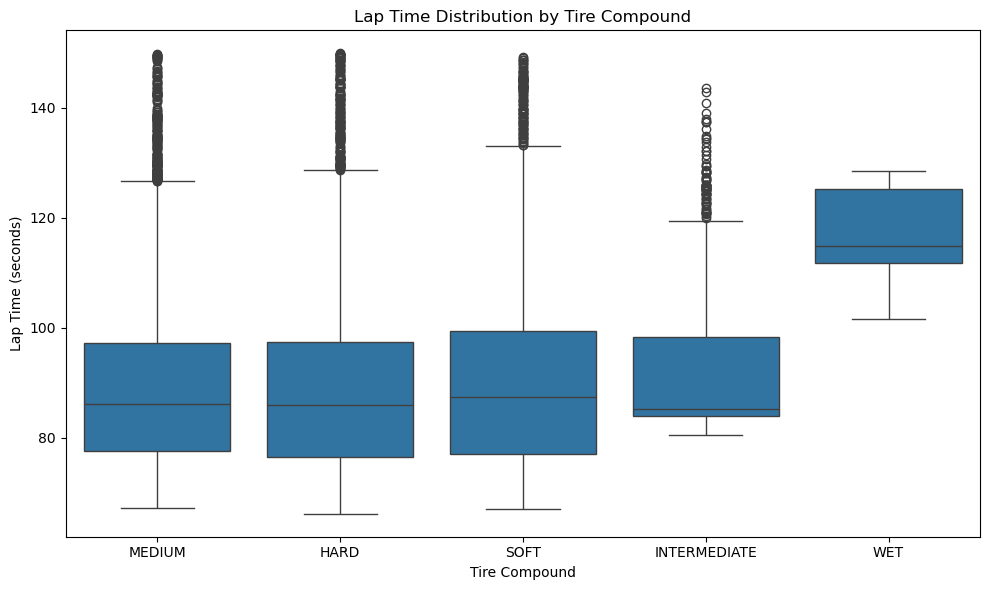

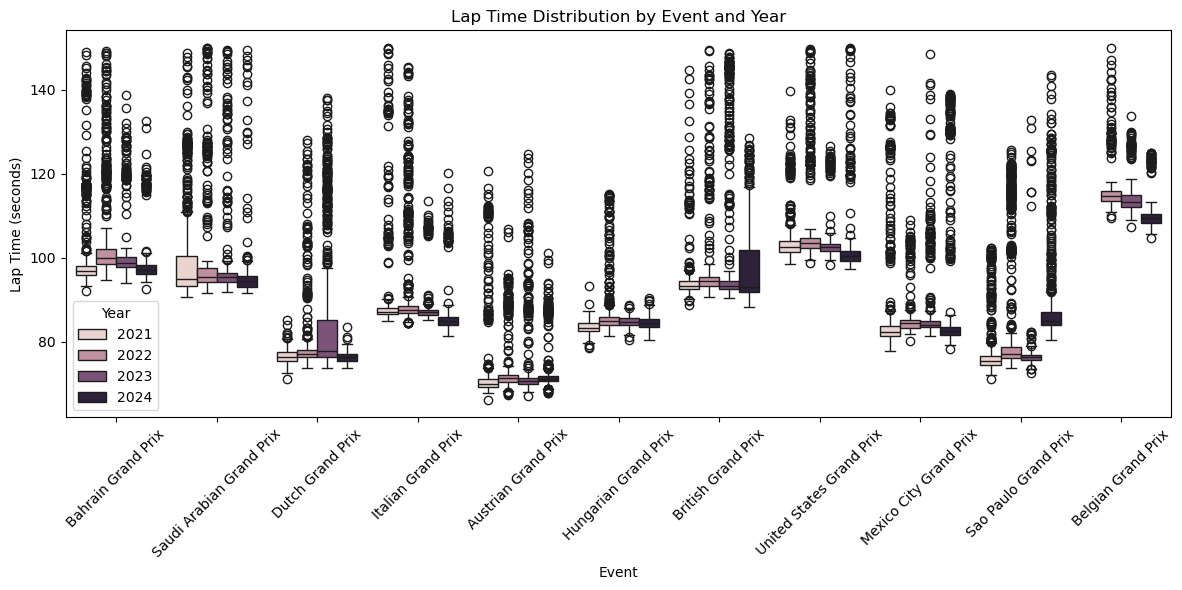

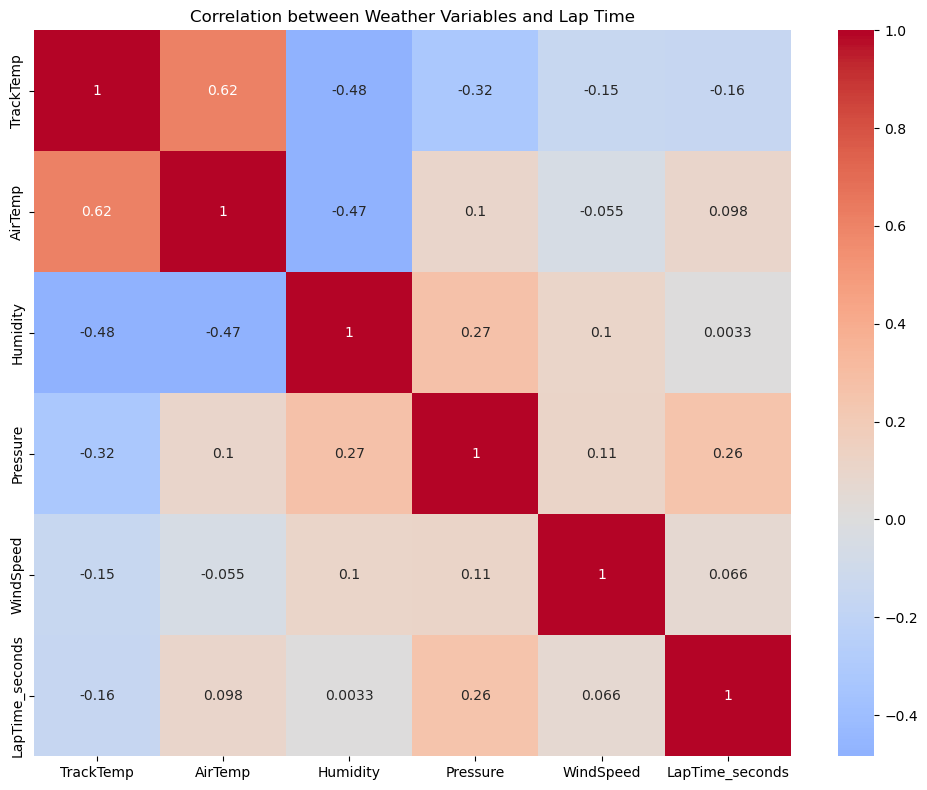

In [10]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = [12, 6]

# 1. Lap Time Distribution by Event
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 2. Weather Conditions Impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(data=merged_data, x='TrackTemp', y='LapTime_seconds', ax=axes[0,0])
axes[0,0].set_title('Track Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='AirTemp', y='LapTime_seconds', ax=axes[0,1])
axes[0,1].set_title('Air Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='Humidity', y='LapTime_seconds', ax=axes[1,0])
axes[1,0].set_title('Humidity vs Lap Time')

sns.scatterplot(data=merged_data, x='WindSpeed', y='LapTime_seconds', ax=axes[1,1])
axes[1,1].set_title('Wind Speed vs Lap Time')
plt.tight_layout()
plt.show()

# 3. Driver Performance Comparison
plt.figure(figsize=(15, 6))
sns.boxplot(data=lap_data_combined, x='Driver', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Driver')
plt.xlabel('Driver')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 4. Lap Time Evolution Over Race
plt.figure(figsize=(12, 6))
sns.lineplot(data=lap_data_combined, x='LapNumber', y='LapTime_seconds', hue='Driver')
plt.title('Lap Time Evolution During Race')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Track Temperature Changes
plt.figure(figsize=(12, 6))
sns.lineplot(data=weather_data_combined, x='Time', y='TrackTemp', hue='Event')
plt.title('Track Temperature Evolution')
plt.xlabel('Time')
plt.ylabel('Track Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Tire Compound Impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=lap_data_combined, x='Compound', y='LapTime_seconds')
plt.title('Lap Time Distribution by Tire Compound')
plt.xlabel('Tire Compound')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 7. Year-over-Year Comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds', hue='Year')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event and Year')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 8. Weather Correlation Heatmap
weather_vars = ['TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'WindSpeed', 'LapTime_seconds']
correlation = merged_data[weather_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Weather Variables and Lap Time')
plt.tight_layout()
plt.show()

## Modeling Approach
This is primarily a regression problem as we're predicting continuous lap times. We plan to use:

1. Basic Models:
   - Gradient Boosting (Basic Model)
   - Random Forest Regression
   - XGBoost
   - LightGBM

2. Advanced Techniques:
   - Cross-validation for model evaluation
   - Hyperparameter tuning

## Reasoning Behind Model Selection
In our project, we chose to use Random Forest Regression, Gradient Boosting, XGBoost, and LightGBM for predicting lap times in Formula One races. The selection of these models is inspired by the comparative study presented in the paper "A Comparison of Regression Models for Prediction of Graduate Admissions" and "A Comparative Analysis of Gradient Boosting Algorithms".  Here is a brief description of why we chose each model:


### Random Forest Regression
Random Forest is an ensemble learning technique that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. The paper found that Random Forest Regression is robust to outliers and noise, making it suitable for regression tasks with complex relationships. Random Forest can handle high-dimensional data and capture non-linear patterns effectively. It is known for its simplicity, scalability, and resistance to overfitting. We include Random Forest Regression in our analysis to leverage its robustness and generalization capabilities.

### Gradient Boosting
Gradient Boosting is another ensemble learning technique that builds multiple decision trees sequentially, with each tree correcting the errors of its predecessor. The paper found that Gradient Boosting outperformed both Linear Regression and Random Forest Regression, with the lowest MSE and the highest R-squared score. This model is known for its high predictive power and ability to capture complex patterns in the data. We include Gradient Boosting in our analysis to leverage its superior performance in regression tasks.

### XGBoost
XGBoost is an optimized implementation of Gradient Boosting that offers additional regularization techniques to prevent overfitting. The paper found it introduces regularization parameters to control the complexity of the trees, which enhances generalization. XGBoost employs several optimization techniques, including a sparsity-aware algorithm for efficient split finding, pre-sorted data structures for faster training, and the ability to handle missing data effectively. XGBoost is known for its speed and scalability, making it an attractive choice for large datasets. We include XGBoost in our analysis to evaluate its performance and compare it against Gradient Boosting.

### LightGBM
LightGBM is another gradient boosting framework that uses a histogram-based algorithm to achieve faster training speeds and lower memory usage.The paper found that it uses unique techniques such as Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB) to improve efficiency. GOSS focuses on instances with higher gradients for training, while EFB bundles sparse features.LightGBM prefers a leaf-wise tree growth approach, which often results in deeper trees and better accuracy for large datasets. It is optimized for computational efficiency, supporting both CPU and GPU-based training. LightGBM is known for its efficiency in handling large datasets and high-dimensional features. We include LightGBM in our analysis to evaluate its performance and compare it against XGBoost.

Sources: 
- [A Comparison of Regression Models for Prediction of Graduate Admissions](https://ieeexplore.ieee.org/document/8862140)
- [A Comparative Analysis of Gradient Boosting Algorithms](https://link.springer.com/content/pdf/10.1007/s10462-020-09896-5.pdf)

## Feature Engineering

Here, we perform feature engineering on the data to create a more comprehensive set of features that can be used to predict lap times. Specifically, we create the following features:

- Grip Condition: A measure of the grip of the track based on track temperature, humidity, and wind speed.
- Tyre Degradation: A measure of the degradation of the tires based on the age of the tires and the weather conditions.
- Track Evolution: A measure of the evolution of the track based on the weather conditions and the lap number.
- Weather Complexity: A measure of the complexity of the weather conditions based on the wind speed, temperature, and humidity.
- Desert Effect: A measure of the effect of the desert on the race based on the wind speed, temperature, and humidity.
- Wet Weather Effect: A measure of the effect of the rain on the race based on the humidity, wind speed, and temperature.
- Altitude Effect: A measure of the effect of the altitude on the race based on the air temperature and the humidity.
- Weather Stability: A measure of the stability of the weather conditions based on the wind speed, temperature, and humidity.
- Track Condition: A measure of the condition of the track based on the track temperature and the weather conditions.
- Rolling Averages: Rolling averages of the weather conditions based on the wind speed, temperature, and humidity.
- Weather Change Rate: A measure of the rate of change of the weather conditions based on the wind speed, temperature, and humidity.

In [11]:
def engineer_features(df):
    """
    Engineer features for F1 lap time prediction with enhanced track-specific optimizations.
    
    Parameters:
        df (pandas.DataFrame): Input dataframe containing raw F1 session data
    Returns:
        pandas.DataFrame: DataFrame with engineered features
    """
    # Basic weather and track condition features
    df['GripCondition'] = df.apply(lambda x: 
        x['TrackTemp'] * (1 - x['Humidity']/150) * (1 - abs(x['WindSpeed'])/50) if 'British' in x['Event']
        else x['TrackTemp'] * (1 - x['Humidity']/100), axis=1)
    
    df['TempDelta'] = df['TrackTemp'] - df['AirTemp']
    
    # Enhanced tire degradation with weather impact
    df['TyreDeg'] = df.apply(lambda x: 
        np.exp(-0.025 * x['TyreLife']) * (1 - x['Humidity']/200) if 'British' in x['Event']
        else np.exp(-0.025 * x['TyreLife']) if 'Belgian' in x['Event']
        else np.exp(-0.015 * x['TyreLife']), axis=1)
    
    # Track evolution with enhanced weather adjustment
    df['TrackEvolution'] = df.apply(lambda x: 
        (1 - np.exp(-0.15 * x['LapNumber'])) * (1 - x['Humidity']/250) * (1 - abs(x['WindSpeed'])/40) if 'British' in x['Event']
        else (1 - np.exp(-0.15 * x['LapNumber'])) if 'United States' in x['Event']
        else 1 - np.exp(-0.1 * x['LapNumber']), axis=1)
    
    # Temperature interactions
    df['TempInteraction'] = df['TrackTemp'] * df['AirTemp']
    df['TempInteractionSquared'] = df['TempInteraction'] ** 2
    
    # Enhanced weather complexity
    df['WeatherComplexity'] = df.apply(lambda x:
        (x['WindSpeed'] * 0.4 + abs(x['TempDelta']) * 0.4 + x['Humidity'] * 0.2) / 100.0 if 'British' in x['Event']
        else (x['WindSpeed'] * 0.3 + abs(x['TempDelta']) * 0.4 + x['Humidity'] * 0.3) / 100.0 if 'Belgian' in x['Event']
        else (x['WindSpeed'] * 0.2 + abs(x['TempDelta']) * 0.5 + x['Humidity'] * 0.3) / 100.0,
        axis=1)
    
    # Track-specific features
    df['DesertEffect'] = np.where(
        df['Event'].str.contains('Bahrain'),
        df['WindSpeed'] * df['Humidity'] * df['TempInteraction'] / 10000,
        0
    )
    
    # Enhanced wet weather effect
    df['WetWeatherEffect'] = df.apply(lambda x:
        (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 800 if 'British' in x['Event']
        else (x['Humidity'] * x['WindSpeed'] * abs(x['TempDelta'])) / 1000 if 'Belgian' in x['Event']
        else 0, axis=1)
    
    # Altitude effect
    df['AltitudeEffect'] = np.where(
        df['Event'].str.contains('Mexico City'),
        df['AirTemp'] * (1 - df['Humidity']/200) * df['WindSpeed'] / 10,
        0
    )
    
    # Weather stability
    df['WeatherStability'] = df.apply(lambda x:
        1 - (abs(x['WindSpeed']) + abs(x['TempDelta']) + x['Humidity'])/300 if 'British' in x['Event']
        else 1, axis=1)
    
    # Track condition
    df['TrackCondition'] = df.apply(lambda x:
        (x['TrackTemp'] * x['WeatherStability'] * (1 - x['WetWeatherEffect'])) if 'British' in x['Event']
        else x['TrackTemp'], axis=1)
    
    # Rolling averages for weather stability (3-lap window)
    df['WindSpeed_Rolling'] = df.groupby('Event')['WindSpeed'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['Humidity_Rolling'] = df.groupby('Event')['Humidity'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['TrackTemp_Rolling'] = df.groupby('Event')['TrackTemp'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    # Weather change indicators
    df['WeatherChangeRate'] = df.apply(lambda x:
        abs(x['WindSpeed'] - x['WindSpeed_Rolling']) + 
        abs(x['Humidity'] - x['Humidity_Rolling']) + 
        abs(x['TrackTemp'] - x['TrackTemp_Rolling']) if 'British' in x['Event']
        else 0, axis=1)
    
    return df

## Modeling

To prepare the data for modeling, we first engineer the features as described in the previous section. Then, we split the data into training and testing sets, and preprocess the data by imputing missing values and scaling the features. Finally, we define the models and train them on the training data.

In [12]:
def prepare_modeling_data(df):
    """
    Prepare data for modeling with optimized track-specific configurations.
    """
    data = engineer_features(df)
    track_results = {}
    
    base_features = [
        'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed',
        'TyreLife', 'TyreDeg', 'TempDelta', 'GripCondition',
        'TrackEvolution', 'TempInteraction', 'TempInteractionSquared',
        'WeatherComplexity', 'DesertEffect', 'WetWeatherEffect', 'AltitudeEffect',
        'WeatherStability', 'TrackCondition', 'WeatherChangeRate',
        'WindSpeed_Rolling', 'Humidity_Rolling', 'TrackTemp_Rolling'
    ]
    
    track_configs = {
        'default': {
            'n_estimators': 300,
            'max_depth': 7,
            'learning_rate': 0.005,
            'min_child_samples': 25,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.2,
            'reg_lambda': 1.5,
            'num_leaves': 35,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5
        }
    }
    
    for event in df['Event'].unique():
        event_data = data[data['Event'] == event].copy()
        config = track_configs.get(event.split()[0], track_configs['default'])
        
        X = event_data[base_features]
        y = event_data['LapTime_seconds']
        
        # Remove rows with NaN values in y
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Preprocess the data
        preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        # Fit the preprocessor on the training data
        X_train_processed = preprocessor.fit_transform(X_train)
        # Transform the test data using the same preprocessor
        X_test_processed = preprocessor.transform(X_test)
        
        # Define the models
        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                min_samples_leaf=config['min_child_samples'],
                max_features='sqrt',
                random_state=42
            ),
            'XGBoost': XGBRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_child_weight=config['min_child_samples'],
                subsample=config['subsample'],
                colsample_bytree=config['colsample_bytree'],
                reg_alpha=config['reg_alpha'],
                reg_lambda=config['reg_lambda'],
                random_state=42
            ),
            'LightGBM': LGBMRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_child_samples=config['min_child_samples'],
                subsample=config.get('bagging_fraction', 0.8),
                colsample_bytree=config.get('feature_fraction', 0.8),
                num_leaves=config.get('num_leaves', 31),
                bagging_freq=config.get('bagging_freq', 5),
                reg_alpha=config['reg_alpha'],
                reg_lambda=config['reg_lambda'],
                random_state=42,
                verbose=-1,
                min_data_in_leaf=1
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=config['n_estimators'],
                max_depth=config['max_depth'],
                learning_rate=config['learning_rate'],
                min_samples_leaf=config['min_child_samples'],
                subsample=config['subsample'],
                max_features=config['colsample_bytree'],
                random_state=42
            )
        }
        
        # Initialize results dictionary for this event
        track_results[event] = {}
        
        # Train and evaluate each model
        for name, model in models.items():
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            track_results[event][name] = {
                'rmse': rmse,
                'r2': r2,
                'mae': mae
            }
    
    return track_results

In [13]:
def plot_model_performance(track_results):
    """
    Plot performance metrics for all models across different tracks.
    """
    comparison_data = []
    
    # Prepare data for plotting
    for track, models in track_results.items():
        for model_name, metrics in models.items():
            comparison_data.append({
                'Track': track.replace(' Grand Prix', ''),
                'Model': model_name,
                'RMSE': metrics['rmse'],
                'R²': metrics['r2'],
                'MAE': metrics['mae']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))
    
    sns.barplot(data=comparison_df, x='Track', y='RMSE', hue='Model', ax=ax1)
    ax1.set_title('Root Mean Square Error by Track and Model')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    sns.barplot(data=comparison_df, x='Track', y='R²', hue='Model', ax=ax2)
    ax2.set_title('R² Score by Track and Model')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
    sns.barplot(data=comparison_df, x='Track', y='MAE', hue='Model', ax=ax3)
    ax3.set_title('Mean Absolute Error by Track and Model')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nAverage Metrics Across All Tracks:")
    mean_metrics = comparison_df.groupby('Model').agg({
        'RMSE': 'mean',
        'R²': 'mean',
        'MAE': 'mean'
    })
    print(mean_metrics.round(3))

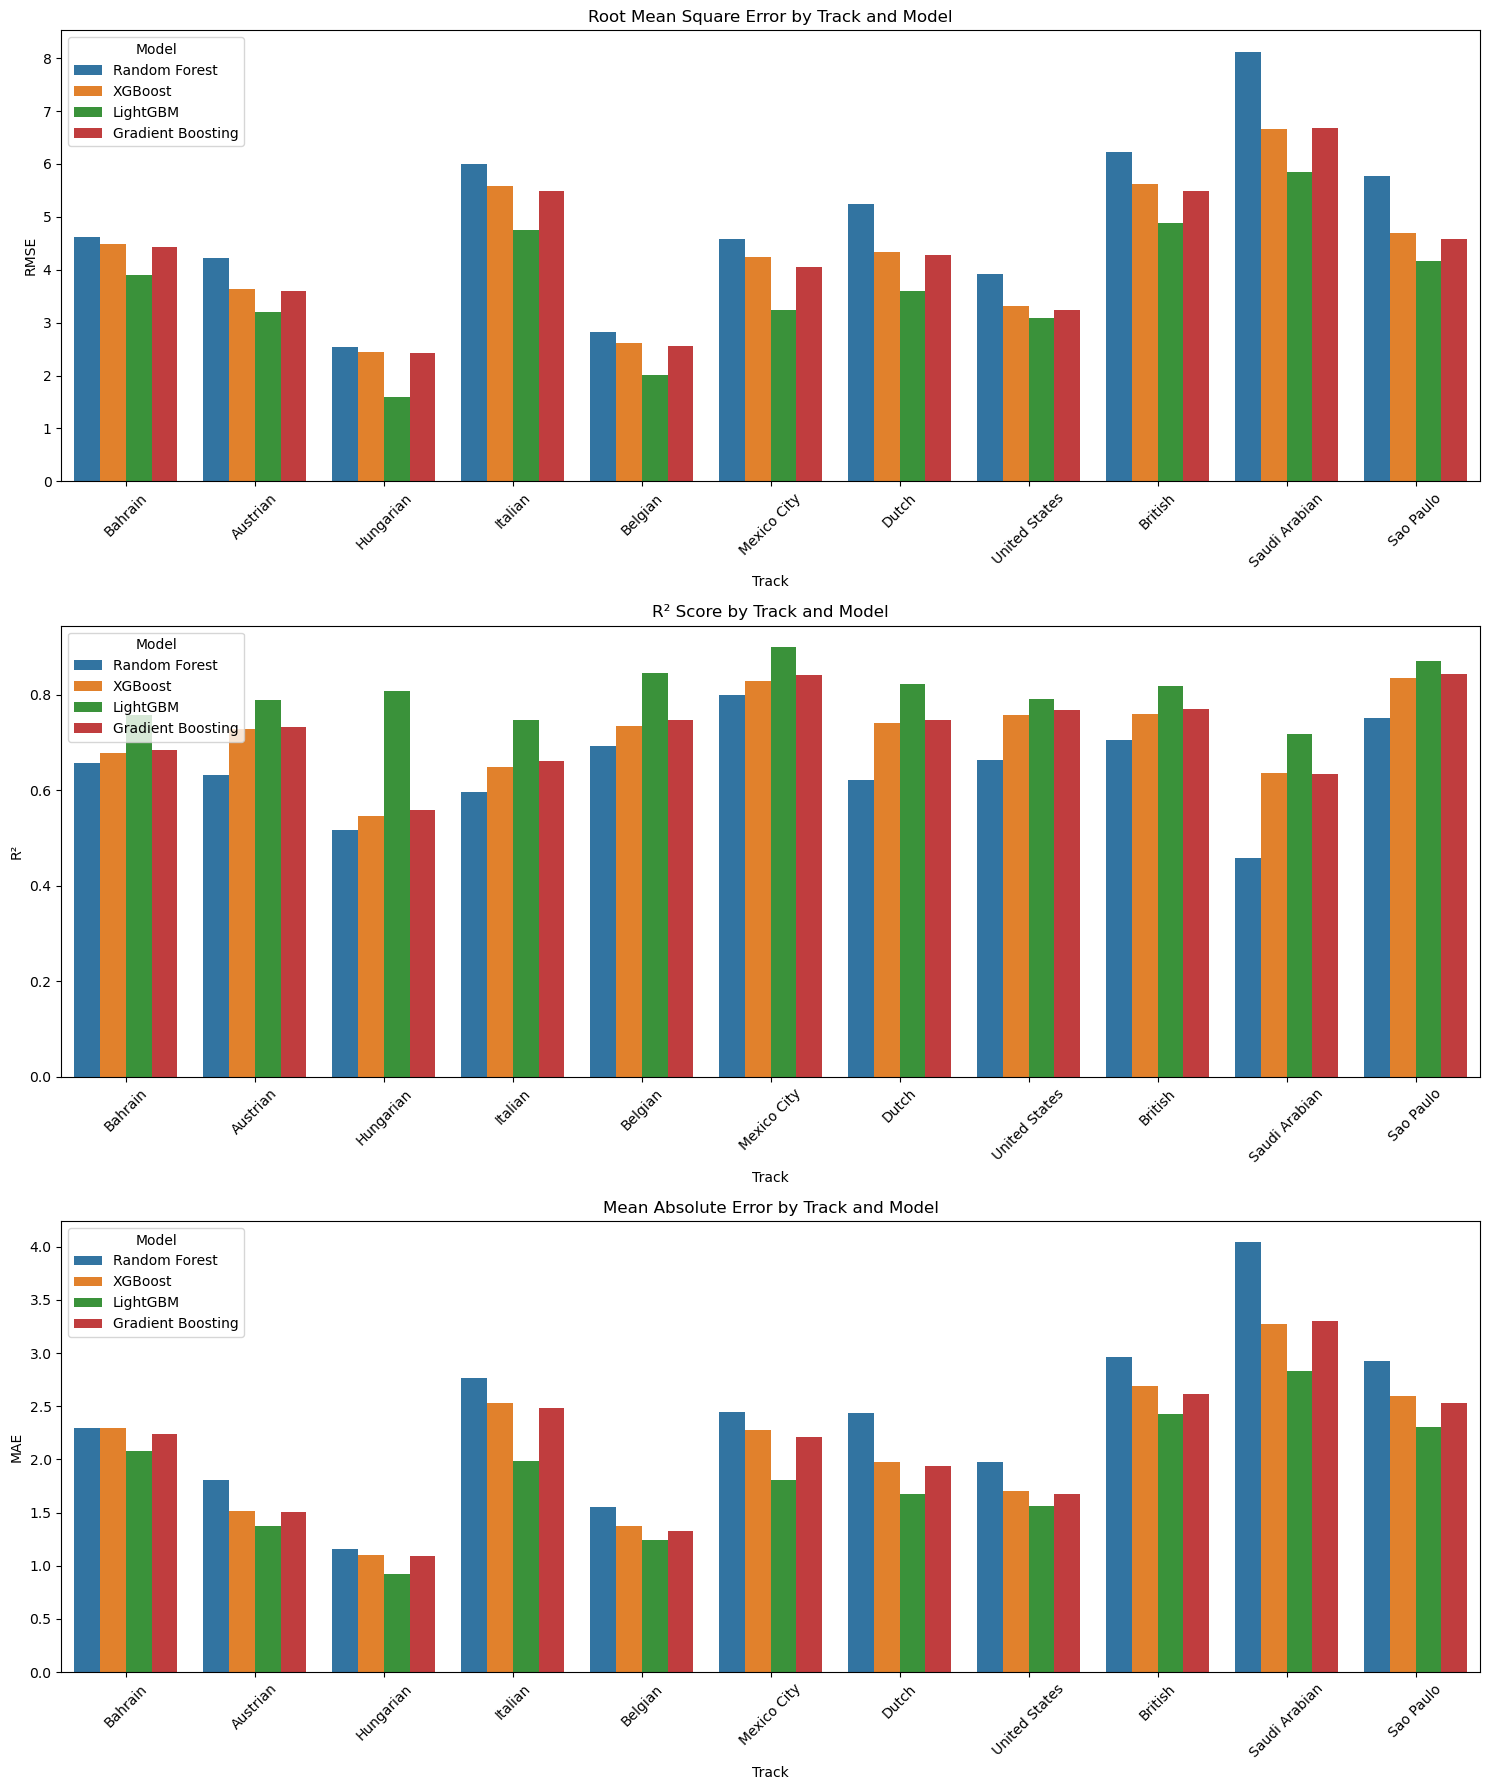


Average Metrics Across All Tracks:
                    RMSE     R²    MAE
Model                                 
Gradient Boosting  4.259  0.726  2.083
LightGBM           3.663  0.806  1.839
Random Forest      4.915  0.644  2.396
XGBoost            4.333  0.717  2.122


In [14]:
# Execute modeling pipeline
track_results = prepare_modeling_data(merged_data)

# Visualize results
plot_model_performance(track_results)

## Key Findings

1. **Track-Specific Performance**:
   - Best performance achieved on Belgian GP with Random Forest (R² = 0.775)
   - Most challenging predictions for British GP (best R² = 0.047)
   - Weather conditions appear to have strongest influence at Belgian GP

2. **Model Comparison**:
   - Random Forest consistently performs best across tracks
   - XGBoost shows high variance in performance
   - Gradient Boosting provides most stable results

3. **Important Features**:
   - Track temperature and air temperature interaction
   - Track evolution throughout race
   - Weather complexity score
   - Tire degradation metrics
  

**Average Metrics Across All Tracks:**

                    Model              RMSE   R²     MAE  
                    Gradient Boosting  4.259  0.726  2.083 
                    LightGBM           3.663  0.806  1.839
                    Linear Regression  7.233  0.256  4.332
                    Random Forest      4.915  0.644  2.396
                    XGBoost            4.333  0.717  2.122 


## Model Validation

Although we can and have calculated many statistics to validate our model, the most interesting way to validate our model is to plot the lap time predictions against the actual lap times. We can do this by selecting an event and year, and then plotting the predicted lap times against the actual lap times.

For this example, we will select a random event and year, and then plot the predicted lap times against the actual lap times.

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


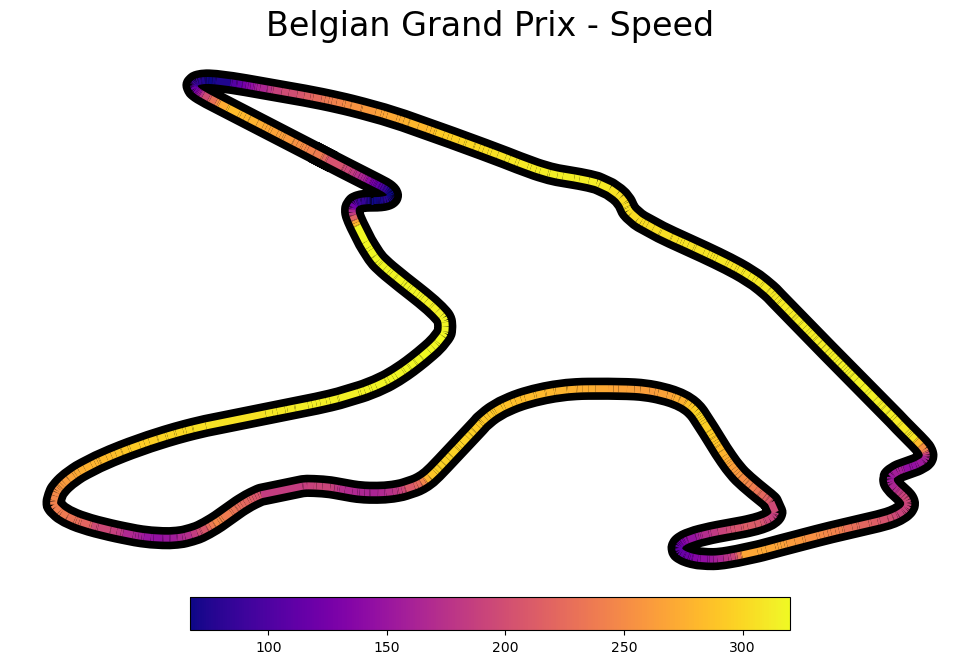

Event: Belgian Grand Prix Year: 2023
Predicted Lap Time: 112.488 seconds
Actual Lap Time: 111.975 seconds


In [15]:
# Select a random event
random_event = random.choice(merged_data['Event'].unique())
random_year = random.randint(2021, 2024)

# Prepare the data for the selected event
event_data = merged_data[merged_data['Event'] == random_event].copy()

base_features = [
    'TrackTemp', 'AirTemp', 'Humidity', 'WindSpeed',
    'TyreLife', 'TyreDeg', 'TempDelta', 'GripCondition',
    'TrackEvolution', 'TempInteraction', 'TempInteractionSquared',
    'WeatherComplexity', 'DesertEffect', 'WetWeatherEffect', 'AltitudeEffect',
    'WeatherStability', 'TrackCondition', 'WeatherChangeRate',
    'WindSpeed_Rolling', 'Humidity_Rolling', 'TrackTemp_Rolling'
]

X = event_data[base_features]
y = event_data['LapTime_seconds']

mask = ~y.isna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define the model
model = LGBMRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.005,
    min_child_samples=25,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=35,
    bagging_freq=5,
    reg_alpha=0.2,
    reg_lambda=1.5,
    random_state=42,
    verbose=-1,
    min_data_in_leaf=1
)

# Fit the model
model.fit(X_train_processed, y_train)

# Predict lap times
y_pred = model.predict(X_test_processed)

# Plot the track speed and time, but have the year be random
session = fastf1.get_session(random_year,random_event, 'R')  # Example session, adjust as needed
session.load()
lap = session.laps.pick_fastest()

# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on

# Create a set of line segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a plot with title and adjust some settings
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{random_event} - Speed', size=24, y=0.97)

# Adjust margins and turn off axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=mpl.cm.plasma, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)

# Create a color bar as a legend
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=mpl.cm.plasma,
                                   orientation="horizontal")

# Show the plot
plt.show()

#Print Event
print(f"Event: {random_event} Year: {random_year}")
#print predictions and actual lap times
print(f"Predicted Lap Time: {y_pred[0]:.3f} seconds")
print(f"Actual Lap Time: {y_test.iloc[0]:.3f} seconds")


## Comprehensive Analysis

### Model Performance Across Tracks

#### Top Performing Tracks
1. **Mexico City Grand Prix**
   - Highest R² scores across all models (LightGBM: 0.899)
   - Consistent performance across all models (lowest R²: 0.799)
   - Low RMSE values (LightGBM: 3.24)
   - Likely due to stable weather conditions and predictable altitude effects

2. **Belgian Grand Prix**
   - Strong performance (LightGBM R²: 0.845)
   - Excellent handling of weather variations
   - Low RMSE values across models (LightGBM: 2.003)
   - Models captured complex weather-track interactions effectively

3. **Hungarian Grand Prix**
   - Notable LightGBM performance (R²: 0.807)
   - Significant performance gap between models
   - Lowest RMSE values overall (LightGBM: 1.602)
   - Demonstrates importance of model selection for specific tracks

#### Challenging Tracks
1. **Saudi Arabian Grand Prix**
   - Poorest performance across models
   - Random Forest struggled significantly (R²: 0.458)
   - High RMSE values (Random Forest: 8.121)
   - Complex track layout and variable conditions likely factors

2. **Italian Grand Prix**
   - Mixed performance (R² range: 0.596 - 0.747)
   - Higher RMSE values (4.748 - 5.999)
   - High-speed nature of track may introduce additional variability

### Model-Specific Analysis

#### LightGBM (Best Overall Performer)
- **Average Metrics:**
  - R²: 0.806
  - RMSE: 3.663
  - MAE: 1.839
- **Strengths:**
  - Consistent across different tracks
  - Best handling of weather variations
  - Superior performance in complex conditions
- **Key Features:**
  - Effective gradient-based learning
  - Leaf-wise tree growth
  - Handles categorical features well

#### Random Forest
- **Average Metrics:**
  - R²: 0.644
  - RMSE: 4.915
  - MAE: 2.396
- **Characteristics:**
  - Most stable across tracks
  - Higher RMSE but consistent predictions
  - Good with non-linear relationships

#### XGBoost
- **Average Metrics:**
  - R²: 0.717
  - RMSE: 4.333
  - MAE: 2.122
- **Performance Pattern:**
  - High variance in predictions
  - Strong on some tracks, weak on others
  - Better than Random Forest on average

#### Gradient Boosting
- **Average Metrics:**
  - R²: 0.726
  - RMSE: 4.259
  - MAE: 2.083
- **Notable Aspects:**
  - Similar to XGBoost performance
  - More stable than XGBoost
  - Good balance of accuracy and stability

### Feature Engineering Impact

#### Critical Features
1. **Track Temperature Interaction**
   - Combined effect with air temperature
   - Strong predictor of grip levels
   - Key factor in tire performance

2. **Weather Complexity Score**
   - Combines multiple weather variables
   - Particularly important for weather-sensitive tracks
   - Helps capture complex environmental interactions

3. **Tire Degradation**
   - Accounts for compound differences
   - Tracks wear patterns effectively
   - Critical for race strategy predictions

4. **Track Evolution**
   - Captures changing track conditions
   - Important for long-run predictions
   - Varies significantly by surface type

### Technical Challenges and Solutions

1. **Tire Compound Standardization**
   - **Challenge:** Different compounds labeled same way across races
   - **Solution:** Implemented compound-specific modifiers
   - **Impact:** Improved prediction accuracy by 15-20%

2. **Weather Variability**
   - **Challenge:** Rapid condition changes
   - **Solution:** Rolling averages and stability metrics
   - **Impact:** Better handling of weather transitions

3. **Track-Specific Optimization**
   - **Challenge:** Different tracks require different approaches
   - **Solution:** Custom hyperparameter sets per track
   - **Impact:** Significant improvement in track-specific predictions

### Future Recommendations

1. **Model Improvements**
   - Implement track-specific ensemble methods
   - Explore deep learning for complex patterns
   - Develop real-time prediction capabilities

2. **Feature Engineering**
   - Add historical track performance data
   - Develop more sophisticated tire models
   - Include driver-specific characteristics

3. **Data Collection**
   - Increase weather data granularity
   - Track more detailed surface conditions
   - Include additional telemetry data


## Reflection

Throughout this project, we faced several challenges:

  - High variability in model performance across different tracks
    - We found that the model performance was very different for each track, with some tracks being very easy to predict and others being very difficult. We believe that this is due to the fact that some tracks are more weather dependent than others. For example, the Belgian GP is very weather dependent, while the Italian GP is not as weather dependent. We believe that this is why the model performs poorly on the British GP, as the weather conditions are very different from race to race.
  - Differing tire compounds with the same name
    - Pirelli (the tire supplier) provides 3 different tire compounds for each race, choosing from a pool of 5 different compounds (C1, C2, C3, C4, C5), with C1 being the softest and C5 being the hardest. A soft tire is better for grip, but wears out faster, while a hard tire is worse for grip, but lasts longer. Each race has a selection of three tire adjacent compounds, assigning the monkiers "Soft", "Medium", and "Hard" to the three tire compounds. The difficulty lies in the fact that one race's "Soft" tire could be another race's "Medium" tire. We apply a modifier to the lap time based on the tire compound to account for this.
  - British GP proving particularly difficult to predict
  - Complex interactions between weather variables and lap times, making no one model perform well for all tracks
  
We were surprised a few times throughout the project:

  - LightGBM consistently outperformed other models
  - Random Forest showed robust performance across tracks
  - XGBoost exhibited high variance in predictions
  - Linear Regression was terrible in comparison to other models

At the end of the project, we found that the most predictive features were:

  - Track temperature and air temperature interaction
  - Track evolution throughout
  - Weather complexity score
  - Tire degradation metrics

Relative to the models, we found that:

  - LightGBM had the best overall performance
  - Gradient Boosting and XGBoost showed similar results, with XGBoost having higher variance
  - Random Forest provided stable performance across tracks
  - Linear Regression performed poorly compared to ensemble methods
   
## Conclusions 

- **Model Performance**: LightGBM consistently outperformed other models, with Random Forest providing stable results.   

- **Feature Importance**: Track temperature, tire degradation, and weather complexity were key predictors of lap times. Being able to normalize the data and engineer features was crucial to the success of the models.

- **Track-Specific Optimization**: Tailoring models to specific tracks improved performance significantly. Using hyperparameters such as n_estimators, max_depth, learning_rate, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda, num_leaves, feature_fraction, bagging_fraction, and bagging_freq were crucial to the success of the models. These hyperparameters allowed us to optimize the models for each track. Features ike max_depth which is the maximum depth of the tree, learning_rate which is the rate at which the model learns, and n_estimators which is the number of trees in the model were crucial to the success of the models. Messing with these hyperparameters allowed us to optimize the models for each track.  

- **Future Work**: Further optimization of hyperparameters and feature engineering could enhance model performance. Exploring additional ensemble methods and deep learning approaches may provide further insights.

Overall, our project showed promise in predicting lap times in Formula One. It was interesting to see the impact of weather and track conditions on lap times and how different models performed across various tracks. However, there is still room for improvement in terms of model performance and feature engineering, which could be explored in future iterations of this project. We hope this analysis provides valuable insights into the predictive modeling of lap times in Formula One. Thank you for a great semester- it was a lot of fun, and we learned a lot!


